In [13]:
import pandas as pd
from itertools import combinations
from gurobipy import *
from clean_data_cor import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [14]:
def read_data(path_dem:str, path_preco:str, path_rota:str):

    demanda = pd.read_csv(path_dem)
    preco = pd.read_csv(path_preco)
    rota0 = pd.read_csv(path_rota)
    rota1 = eval(rota0['Route'][0])

    return demanda, preco, rota1


def create_sets(demanda, preco_, rota1, perio=0):

    if perio != 0:
        periodo_lim = sorted(demanda['DBD'].unique().tolist())[:perio]
        demanda = demanda[demanda['DBD'].isin(periodo_lim)]

    rota = [0] + rota1
    
    I, J, OD, V,  T, stations, VK, P, d = clean_data(demanda, preco_)

    # AD = [(i,j) for i,j in OD if rota1.index(j) == rota1.index(i)+1]
    NAD = [(i,j) for i,j in OD if rota1.index(j) != rota1.index(i)+1]

    I = [i for i in rota if i in I]
    I2 = [0] + I# tambem se toma para el para tudo da restriccion de fluxo
    J = [i for i in rota if i in J]
    n = len(rota)-1

    BR = {}
    for i,j in NAD:
        listTemp = list(combinations(rota1[rota1.index(i):rota1.index(j)+1], 2))
        listTemp =  {(ii,jj) for ii,jj in listTemp if (ii,jj) in OD and (ii, jj) != (i,j)} #rota1.index(jj) == rota1.index(ii)+1 and 
        BR[(i,j)] = listTemp

    # indices
    index0 = [(i,j,v,k,t) for i in I2 for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
    index1 = [(i,j,v,k,t) for i in I for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
    index = [(i,j,v,k,t) for i,j in BR.keys() for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]

    return I, I2, J, OD, NAD, V,  T, stations, VK, P, d, n, BR, I2, index0, index, index1


def create_model(I, I2, J, V, VK, T, OD, NAD, BR, P, Q, d, index0, index, index1, rota):
    model = Model("Modelo prueba")

    # variables de decicion
    X = model.addVars(index0, vtype=GRB.INTEGER , name="X")
    Y = model.addVars(index1, vtype=GRB.INTEGER , name="Y")
    A = model.addVars(I2, vtype=GRB.INTEGER , name="A")
    BNA = model.addVars(index, vtype=GRB.BINARY , name="BNA")


    # funcion objetivo
    model.setObjective(
        quicksum(P[(i,j,v,k)]*X[(i,j,v,k,t)] for i,j in OD for v in V for k in VK[v] for t in T), 
        sense = GRB.MAXIMIZE
    )

    # restricciones
    for i in I:

        # restricao .2
        model.addConstr(
            A[i] == A[rota[rota.index(i)-1]] - 
                    quicksum(X[rota[rota.index(i)-1],j,v,k,t] for j in J for v in V for k in VK[v] for t in T if (rota[rota.index(i)-1] != j) and (rota[rota.index(i)-1],j) in OD) + 
                    quicksum(X[j,i,v,k,t] for j in I for v in V for k in VK[v] for t in T if rota.index(j) < 
                    rota.index(i) and (j,i) in OD),
                    
                    name=f"Dispo_{i}"
        )

        # restricao .3
        model.addConstr(
            quicksum((X[i,j,v,k,t]) for j in J for v in V for k in VK[v] for t in T if i != j and (i,j) in OD) <= A[i],
            name=f"Cap_{i}"
        )

        # restricao .6
        model.addConstr(
            quicksum(Y[i,j,v,VK[v][0],t] for j in J for v in V for t in T if i != j and (i,j) in OD) <= Q, 
            name=f"AuthoCap_{i}"
        )


    for i,j in OD:
        for v in V:
            for k in VK[v]:
                for t in T:

                    pos_k = VK[v].index(k)

                    # restricao .5
                    model.addConstr(
                        X[i,j,v,k,t] <= d[i,j,v,k,t],
                        name = f"Assig_({i},{j},{v},{k},{t})"
                    )

                    # # # restricao .XXXXXXXXXXXXXXXXXXXXXXXXX
                    # if pos_k >= 1:
                    #     model.addConstr(
                    #         quicksum(X[i,j,v,kk,t] for kk in VK[v][0:pos_k+1]) <= d[i,j,v,k,t],
                    #         name = f"DemComp({i},{j},{v},{k},{t})"
                    #     )

                    if k != VK[v][-1]:
                        # restricao .4
                        model.addConstr(
                            Y[i,j,v,k,t] >= Y[i,j,v,VK[v][pos_k+1],t], 
                            name=f"Classe_({i},{j},{v},{k},{t})"
                        )

                        # restricao .8
                        model.addConstr(
                            Y[i,j,v,k,t] >=  X[i,j,v,k,t] + Y[i,j,v,VK[v][pos_k+1],t],
                            name=f"Autho_({i},{j},{v},{k},{t})"
                        )
                    else:

                        # restricao .7
                        model.addConstr(
                            Y[i,j,v,k,t] >=  X[i,j,v,k,t],
                            name=f"Autho_({i},{j},{v},{k},{t})"
                        )


    # [start] --- Restricciones de Capitalismo
    for o,d_ in NAD:

        for v in V:
            for k in VK[v]:
                for t in T:
                    
                    # restricao .9.1
                    model.addConstr(
                        BNA[o,d_,v,k,t] <= Y[o,d_,v,k,t],
                        # name = f"activ_bin_autho_low_({o},{d_},{v},{k},{t})"
                    )
                    
                    # restricao .9.2
                    model.addConstr(
                        Y[o,d_,v,k,t] <= Q*BNA[o,d_,v,k,t],
                        # name = f"activ_bin_autho_top_({o},{d_},{v},{k},{t})"
                    )

        for i,j in BR[o,d_]:
            for v in V:
                for k in VK[v]:
                    for t in T:
                        
                        # restricao .10.1
                        model.addConstr(
                            Y[i,j,v,k,t] <= Q*BNA[o,d_,v,k,t],
                            # name = f"pru1({o},{d_},{i},{j},{v},{k},{t})"
                        )

                        # restricao .10.2
                        model.addConstr(
                            BNA[o,d_,v,k,t] <= Y[i,j,v,k,t],
                            # name = f"pru2({o},{d_},{i},{j},{v},{k},{t})"
                        )


    # [end] --- Restricciones de Capitalismo


    for j in J:
        for v in V:
            for k in VK[v]:
                for t in T:

                    # restricao .11
                    model.addConstr(
                        X[0,j,v,k,t] == 0,
                        name = f"Assig_({0},{j},{v},{k},{t})"
                    )

    # restricao .12
    model.addConstr(
        A[0] == Q,
        name = f"Cap_0"
    )

    return model, A, X, Y, BNA


def save_solution(model, OD, V, VK, T, BR, P, d, X, Y, BNA, perio, instance):
    print('Valor da função objetivo: ', str(model.ObjVal) )
    print('')
    lista = []
    for i,j in OD:
        for v in V:
            for k in VK[v]:
                for t in T:
                    if (i,j) in BR.keys():
                        lista.append([i+'-'+j,i,j,v, k, t, P[i,j,v,k], d[i,j,v,k,t], X[i,j,v,k,t].X, Y[i,j,v,k,t].X , BNA[i,j,v,k,t].X ])
                    else:
                        lista.append([i+'-'+j,i,j,v, k, t, P[i,j,v,k], d[i,j,v,k,t], X[i,j,v,k,t].X, Y[i,j,v,k,t].X , -1 ])

    a = pd.DataFrame(lista, columns=['o-d',"Origen","Destino",'Vagon','classe','Periodo','Preco','Demanda','Assignments','Authorizations','Binaria'])
    
    # a.to_excel('modelo1_'+instance+'_t'+str(perio)+'.xlsx', index=False)

    return a


In [15]:
import random 
rota1 = ['uno','dos','tres', 'cuatro', 'cinco']
rota = [0] + rota1

OD = [('uno','dos'),
    ('uno','tres'),
    ('uno','cuatro'),
    ('uno','cinco'),
    ('dos','tres'),
    ('dos','cuatro'),
    ('dos','cinco'),
    ('tres','cuatro'),
    ('tres','cinco'),
    ('cuatro','cinco'),]

AD = [(i,j) for i,j in OD if rota1.index(j) == rota1.index(i)+1]
NAD = [(i,j) for i,j in OD if rota1.index(j) != rota1.index(i)+1]

BR = {}
for i,j in NAD:
    listTemp = list(combinations(rota1[rota1.index(i):rota1.index(j)+1], 2))
    listTemp =  {(ii,jj) for ii,jj in listTemp if (ii,jj) in OD and (ii, jj) != (i,j)} #rota1.index(jj) == rota1.index(ii)+1 and 
    BR[(i,j)] = listTemp


I = ['uno','dos','tres', 'cuatro']
I2 = [0] + I
J = ['dos','tres','cuatro', 'cinco']
V = ['p','z']
T = [0,1]
Q = 700 
n = len(rota) - 1 
VK = {'p':[1,5,7],'z':[1,3,7]}

# indices
index0 = [(i,j,v,k,t) for i in I2 for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
index1 = [(i,j,v,k,t) for i in I for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
index = [(i,j,v,k,t) for i,j in BR.keys() for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]

In [16]:
# # [start] calcular la demanda 
# dd = {(i,j,v,k,t): np.random.randint(1,100) for i,j in OD for v in V for k in VK[v] for t in T }


# P = {}
# for i,j in OD:
#     for v in V:
#         aleat = sorted(random.sample(range(50, 2000 + 1), len(VK[v])), reverse=True)
#         for k,valor in enumerate(aleat):
#             P[(i,j,v,VK[v][k])] = valor


In [17]:
d = {('uno', 'dos', 'p', 1, 0): 82,
 ('uno', 'dos', 'p', 1, 1): 29,
 ('uno', 'dos', 'p', 5, 0): 73,
 ('uno', 'dos', 'p', 5, 1): 61,
 ('uno', 'dos', 'p', 7, 0): 29,
 ('uno', 'dos', 'p', 7, 1): 55,
 ('uno', 'dos', 'z', 1, 0): 32,
 ('uno', 'dos', 'z', 1, 1): 75,
 ('uno', 'dos', 'z', 3, 0): 91,
 ('uno', 'dos', 'z', 3, 1): 52,
 ('uno', 'dos', 'z', 7, 0): 14,
 ('uno', 'dos', 'z', 7, 1): 40,
 ('uno', 'tres', 'p', 1, 0): 16,
 ('uno', 'tres', 'p', 1, 1): 12,
 ('uno', 'tres', 'p', 5, 0): 53,
 ('uno', 'tres', 'p', 5, 1): 52,
 ('uno', 'tres', 'p', 7, 0): 7,
 ('uno', 'tres', 'p', 7, 1): 5,
 ('uno', 'tres', 'z', 1, 0): 53,
 ('uno', 'tres', 'z', 1, 1): 62,
 ('uno', 'tres', 'z', 3, 0): 60,
 ('uno', 'tres', 'z', 3, 1): 15,
 ('uno', 'tres', 'z', 7, 0): 68,
 ('uno', 'tres', 'z', 7, 1): 74,
 ('uno', 'cuatro', 'p', 1, 0): 47,
 ('uno', 'cuatro', 'p', 1, 1): 53,
 ('uno', 'cuatro', 'p', 5, 0): 30,
 ('uno', 'cuatro', 'p', 5, 1): 65,
 ('uno', 'cuatro', 'p', 7, 0): 77,
 ('uno', 'cuatro', 'p', 7, 1): 32,
 ('uno', 'cuatro', 'z', 1, 0): 53,
 ('uno', 'cuatro', 'z', 1, 1): 69,
 ('uno', 'cuatro', 'z', 3, 0): 60,
 ('uno', 'cuatro', 'z', 3, 1): 73,
 ('uno', 'cuatro', 'z', 7, 0): 91,
 ('uno', 'cuatro', 'z', 7, 1): 88,
 ('uno', 'cinco', 'p', 1, 0): 50,
 ('uno', 'cinco', 'p', 1, 1): 90,
 ('uno', 'cinco', 'p', 5, 0): 31,
 ('uno', 'cinco', 'p', 5, 1): 51,
 ('uno', 'cinco', 'p', 7, 0): 24,
 ('uno', 'cinco', 'p', 7, 1): 46,
 ('uno', 'cinco', 'z', 1, 0): 14,
 ('uno', 'cinco', 'z', 1, 1): 71,
 ('uno', 'cinco', 'z', 3, 0): 6,
 ('uno', 'cinco', 'z', 3, 1): 68,
 ('uno', 'cinco', 'z', 7, 0): 9,
 ('uno', 'cinco', 'z', 7, 1): 43,
 ('dos', 'tres', 'p', 1, 0): 69,
 ('dos', 'tres', 'p', 1, 1): 24,
 ('dos', 'tres', 'p', 5, 0): 73,
 ('dos', 'tres', 'p', 5, 1): 41,
 ('dos', 'tres', 'p', 7, 0): 78,
 ('dos', 'tres', 'p', 7, 1): 63,
 ('dos', 'tres', 'z', 1, 0): 46,
 ('dos', 'tres', 'z', 1, 1): 29,
 ('dos', 'tres', 'z', 3, 0): 24,
 ('dos', 'tres', 'z', 3, 1): 51,
 ('dos', 'tres', 'z', 7, 0): 76,
 ('dos', 'tres', 'z', 7, 1): 3,
 ('dos', 'cuatro', 'p', 1, 0): 30,
 ('dos', 'cuatro', 'p', 1, 1): 16,
 ('dos', 'cuatro', 'p', 5, 0): 31,
 ('dos', 'cuatro', 'p', 5, 1): 80,
 ('dos', 'cuatro', 'p', 7, 0): 7,
 ('dos', 'cuatro', 'p', 7, 1): 17,
 ('dos', 'cuatro', 'z', 1, 0): 75,
 ('dos', 'cuatro', 'z', 1, 1): 69,
 ('dos', 'cuatro', 'z', 3, 0): 70,
 ('dos', 'cuatro', 'z', 3, 1): 95,
 ('dos', 'cuatro', 'z', 7, 0): 14,
 ('dos', 'cuatro', 'z', 7, 1): 78,
 ('dos', 'cinco', 'p', 1, 0): 17,
 ('dos', 'cinco', 'p', 1, 1): 99,
 ('dos', 'cinco', 'p', 5, 0): 61,
 ('dos', 'cinco', 'p', 5, 1): 6,
 ('dos', 'cinco', 'p', 7, 0): 36,
 ('dos', 'cinco', 'p', 7, 1): 99,
 ('dos', 'cinco', 'z', 1, 0): 18,
 ('dos', 'cinco', 'z', 1, 1): 27,
 ('dos', 'cinco', 'z', 3, 0): 96,
 ('dos', 'cinco', 'z', 3, 1): 79,
 ('dos', 'cinco', 'z', 7, 0): 4,
 ('dos', 'cinco', 'z', 7, 1): 54,
 ('tres', 'cuatro', 'p', 1, 0): 39,
 ('tres', 'cuatro', 'p', 1, 1): 43,
 ('tres', 'cuatro', 'p', 5, 0): 95,
 ('tres', 'cuatro', 'p', 5, 1): 41,
 ('tres', 'cuatro', 'p', 7, 0): 20,
 ('tres', 'cuatro', 'p', 7, 1): 87,
 ('tres', 'cuatro', 'z', 1, 0): 94,
 ('tres', 'cuatro', 'z', 1, 1): 59,
 ('tres', 'cuatro', 'z', 3, 0): 30,
 ('tres', 'cuatro', 'z', 3, 1): 46,
 ('tres', 'cuatro', 'z', 7, 0): 66,
 ('tres', 'cuatro', 'z', 7, 1): 61,
 ('tres', 'cinco', 'p', 1, 0): 19,
 ('tres', 'cinco', 'p', 1, 1): 26,
 ('tres', 'cinco', 'p', 5, 0): 68,
 ('tres', 'cinco', 'p', 5, 1): 59,
 ('tres', 'cinco', 'p', 7, 0): 64,
 ('tres', 'cinco', 'p', 7, 1): 46,
 ('tres', 'cinco', 'z', 1, 0): 48,
 ('tres', 'cinco', 'z', 1, 1): 84,
 ('tres', 'cinco', 'z', 3, 0): 98,
 ('tres', 'cinco', 'z', 3, 1): 69,
 ('tres', 'cinco', 'z', 7, 0): 18,
 ('tres', 'cinco', 'z', 7, 1): 6,
 ('cuatro', 'cinco', 'p', 1, 0): 99,
 ('cuatro', 'cinco', 'p', 1, 1): 88,
 ('cuatro', 'cinco', 'p', 5, 0): 35,
 ('cuatro', 'cinco', 'p', 5, 1): 61,
 ('cuatro', 'cinco', 'p', 7, 0): 22,
 ('cuatro', 'cinco', 'p', 7, 1): 1,
 ('cuatro', 'cinco', 'z', 1, 0): 84,
 ('cuatro', 'cinco', 'z', 1, 1): 85,
 ('cuatro', 'cinco', 'z', 3, 0): 20,
 ('cuatro', 'cinco', 'z', 3, 1): 45,
 ('cuatro', 'cinco', 'z', 7, 0): 12,
 ('cuatro', 'cinco', 'z', 7, 1): 13}

P = {('uno', 'dos', 'p', 1): 1667,
 ('uno', 'dos', 'p', 5): 1479,
 ('uno', 'dos', 'p', 7): 1221,
 ('uno', 'dos', 'z', 1): 1888,
 ('uno', 'dos', 'z', 3): 644,
 ('uno', 'dos', 'z', 7): 205,
 ('uno', 'tres', 'p', 1): 1686,
 ('uno', 'tres', 'p', 5): 833,
 ('uno', 'tres', 'p', 7): 769,
 ('uno', 'tres', 'z', 1): 781,
 ('uno', 'tres', 'z', 3): 708,
 ('uno', 'tres', 'z', 7): 464,
 ('uno', 'cuatro', 'p', 1): 1961,
 ('uno', 'cuatro', 'p', 5): 1872,
 ('uno', 'cuatro', 'p', 7): 1086,
 ('uno', 'cuatro', 'z', 1): 1346,
 ('uno', 'cuatro', 'z', 3): 778,
 ('uno', 'cuatro', 'z', 7): 426,
 ('uno', 'cinco', 'p', 1): 1936,
 ('uno', 'cinco', 'p', 5): 1601,
 ('uno', 'cinco', 'p', 7): 283,
 ('uno', 'cinco', 'z', 1): 1726,
 ('uno', 'cinco', 'z', 3): 1389,
 ('uno', 'cinco', 'z', 7): 1260,
 ('dos', 'tres', 'p', 1): 1871,
 ('dos', 'tres', 'p', 5): 915,
 ('dos', 'tres', 'p', 7): 593,
 ('dos', 'tres', 'z', 1): 972,
 ('dos', 'tres', 'z', 3): 640,
 ('dos', 'tres', 'z', 7): 284,
 ('dos', 'cuatro', 'p', 1): 1969,
 ('dos', 'cuatro', 'p', 5): 378,
 ('dos', 'cuatro', 'p', 7): 129,
 ('dos', 'cuatro', 'z', 1): 1650,
 ('dos', 'cuatro', 'z', 3): 1619,
 ('dos', 'cuatro', 'z', 7): 1222,
 ('dos', 'cinco', 'p', 1): 1461,
 ('dos', 'cinco', 'p', 5): 205,
 ('dos', 'cinco', 'p', 7): 128,
 ('dos', 'cinco', 'z', 1): 1253,
 ('dos', 'cinco', 'z', 3): 633,
 ('dos', 'cinco', 'z', 7): 462,
 ('tres', 'cuatro', 'p', 1): 1336,
 ('tres', 'cuatro', 'p', 5): 392,
 ('tres', 'cuatro', 'p', 7): 388,
 ('tres', 'cuatro', 'z', 1): 1380,
 ('tres', 'cuatro', 'z', 3): 1376,
 ('tres', 'cuatro', 'z', 7): 297,
 ('tres', 'cinco', 'p', 1): 1892,
 ('tres', 'cinco', 'p', 5): 1805,
 ('tres', 'cinco', 'p', 7): 1435,
 ('tres', 'cinco', 'z', 1): 1952,
 ('tres', 'cinco', 'z', 3): 1702,
 ('tres', 'cinco', 'z', 7): 1562,
 ('cuatro', 'cinco', 'p', 1): 1269,
 ('cuatro', 'cinco', 'p', 5): 538,
 ('cuatro', 'cinco', 'p', 7): 204,
 ('cuatro', 'cinco', 'z', 1): 737,
 ('cuatro', 'cinco', 'z', 3): 357,
 ('cuatro', 'cinco', 'z', 7): 60}


# corrigir instancias
d = {(i,j,v,k,t): d[(i,j,v,k,t)] if (i,j,v,k,t) in d else 0  for i,j in OD for v in V for k in VK[v] for t in T}
P = {(i,j,v,k): P[(i,j,v,k)] if (i,j,v,k) in P else 0  for i,j in OD for v in V for k in VK[v] }

In [18]:
# Criar Conjuntos
# criar modelo
model, A, X, Y, BNA = create_model(I, I2, J, V, VK, T, OD, NAD, BR, P, Q, d, index0, index, index1, rota)

# Optimizar o modelo
model.optimize()

model.write("cmodeloMatematico.lp")

# Salvar solucao
a = save_solution(model, OD, V, VK, T, BR, P, d, X, Y, BNA, 2, "prueba")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 5 2500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1125 rows, 365 columns and 2417 nonzeros
Model fingerprint: 0xdecac246
Variable types: 0 continuous, 365 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  Objective range  [6e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 766 rows and 116 columns
Presolve time: 0.01s
Presolved: 359 rows, 249 columns, 1015 nonzeros
Variable types: 0 continuous, 249 integer (13 binary)

Root relaxation: objective 2.917640e+06, 152 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

attrs = ['Authorizations','Assignments','Demanda','Preco']

def grafica(a, attrs, h, l, ng, p=-1):
    if p != -1:
        a = a[a['Periodo']==p]

    dfs = []
    for attr in attrs:
        if attr != 'preco':
            df = pd.pivot_table(a, values=attr, index='o-d', columns=['Vagon','classe'], aggfunc={attr:'sum'})
        else:
            df = pd.pivot_table(a, values=attr, index='o-d', columns=['Vagon','classe'], aggfunc={attr:'max'})
        dfs.append(df)

    fig, ax = plt.subplots(1, ng, figsize=(l, h)) 
    # plt.figure(figsize=(4, 3))  # Ajusta el ancho a 8 y la altura a 6

    colores = [(0, 'red'), (0.006, 'yellow'), (0.75, 'orange'), (1, 'green')] 
    cmap_customi = LinearSegmentedColormap.from_list('mi_colormap', colores)

    cont = 0
    for df in dfs:
        # Agregar una escala de color usando pcolor
        ax[cont].pcolor(df, cmap=cmap_customi, edgecolors='w', linewidths=2)
        # plt.colorbar(ax[cont].pcolor(df, cmap=cmap_customi, edgecolors='w', linewidths=2))

        # Añadir etiquetas de los ejes
        if cont == 0:
            ax[cont].set_yticks(np.arange(0.5, len(df.index)), df.index)
        ax[cont].set_xticks(np.arange(0.5, len(df.columns)), df.columns)

        ax[cont].xaxis.set_ticks_position('top')
        ax[cont].tick_params(axis='x', rotation=45, labelsize=8)

        # Agregar valores numéricos a cada celda
        for i in range(len(df.index)):
            for j in range(len(df.columns)):
                ax[cont].text(j + 0.5, i + 0.5, str(int(df.iloc[i, j])), color='black', ha='center', va='center')

        # Añadir título y etiquetas
        ax[cont].set_title(attrs[cont])

        cont += 1

    # fig.show()

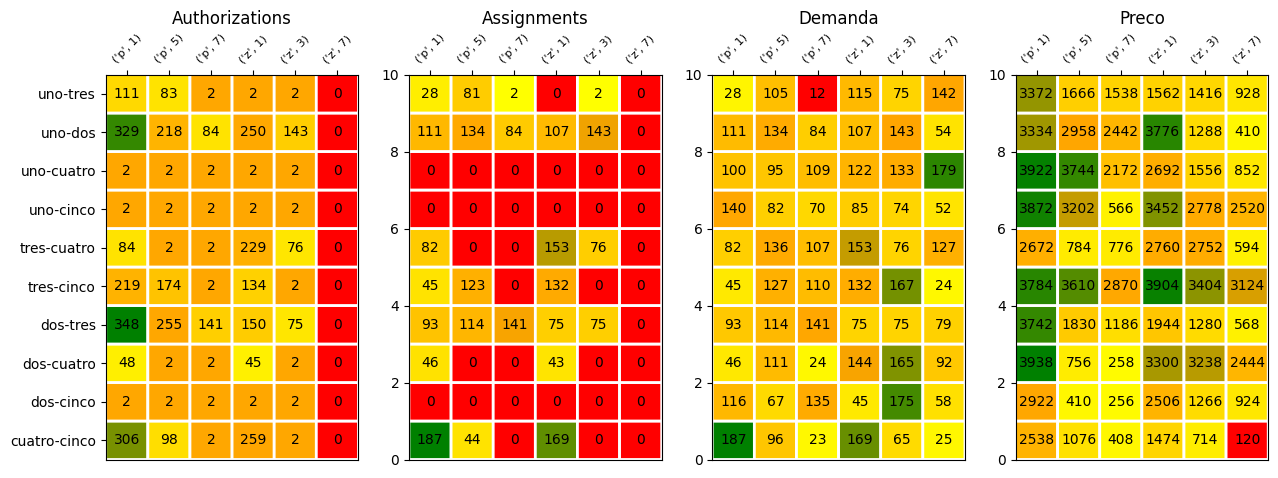

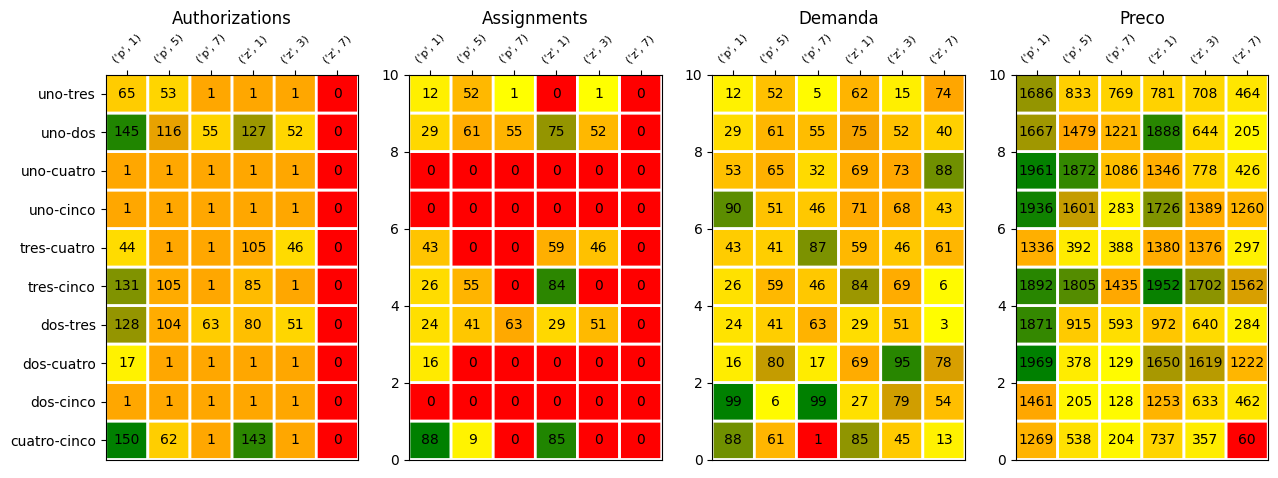

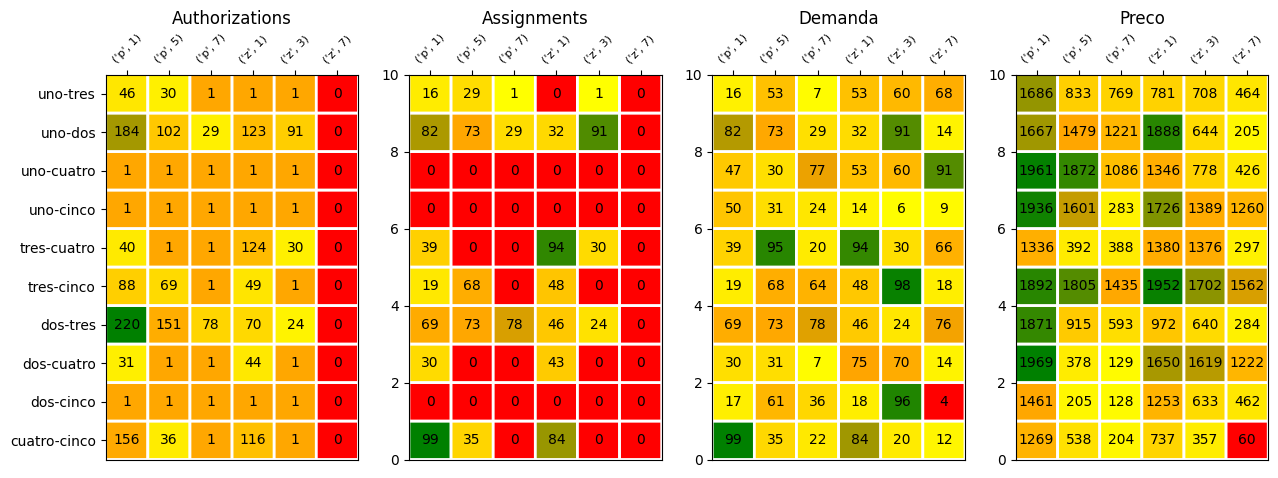

In [20]:
grafica(a,attrs, 5, 15, 4)
grafica(a,attrs, 5, 15, 4, 1)
grafica(a,attrs, 5, 15, 4, 0)

In [21]:
# # [start] calcular la demanda 
# dd = {(i,j,v,k,t): np.random.randint(1,100) for i,j in OD for v in V for k in VK[v] for t in T }

# df = pd.DataFrame.from_dict(dd, orient="index")
# df.reset_index(inplace=True)
# df[['i', 'j', 'v', 'k', 't']] = pd.DataFrame(df['index'].tolist(), index=df.index)
# df = df.drop("index", axis=1)

# # aqui se esta creando una nueva columna "DemandaComport" que tendra la lista
# # de preferencia de la demanda potencial para cada clase
# df["DemandaComport"] = df.apply(lambda fila: VK[fila["v"]][VK[fila["v"]].index(fila["k"]):][::-1] , axis=1)
# df["DemPotencialTot"] = df.apply(dem_compor, axis=1)
# df = df[['i', 'j', 'v', 'k', 't', 0, 'DemandaComport', 'DemPotencialTot']]
# df.columns = ['Origin', 'Destination', 'Vagon', 'Class', 'DBD', "Booking", 'PL', 'DemPot']
# d =  df.copy()
# d = d.set_index(['Origin', 'Destination', 'Vagon', 'Class', 'DBD'])['DemPot'].to_dict()
# # [end] calcular la demanda 


# P = {}
# for i,j in OD:
#     for v in V:
#         aleat = sorted(random.sample(range(50, 2000 + 1), len(VK[v])), reverse=True)
#         for k,valor in enumerate(aleat):
#             P[(i,j,v,VK[v][k])] = valor